In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv
/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv
/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv
/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/22341.txt
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/20430.txt
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/1893.txt
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/7360.txt
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/1711.txt
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/13052.txt
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/4682.txt
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos/5450.txt
/kaggle/input/arabic-sentiment-twitter-corpus/arabic_tweets/pos

In [70]:
import pandas as pd
import os


base_path = "/kaggle/input/arabic-sentiment-twitter-corpus"


positive_train = pd.read_csv(os.path.join(base_path, "train_Arabic_tweets_positive_20190413.tsv"), sep="\t", header=None, names=["tweet"])
negative_train = pd.read_csv(os.path.join(base_path, "train_Arabic_tweets_negative_20190413.tsv"), sep="\t", header=None, names=["tweet"])
positive_test  = pd.read_csv(os.path.join(base_path, "test_Arabic_tweets_positive_20190413.tsv"), sep="\t", header=None, names=["tweet"])
negative_test  = pd.read_csv(os.path.join(base_path, "test_Arabic_tweets_negative_20190413.tsv"), sep="\t", header=None, names=["tweet"])


positive_train["sentiment"] = "positive"
negative_train["sentiment"] = "negative"
positive_test["sentiment"]  = "positive"
negative_test["sentiment"]  = "negative"


df = pd.concat([positive_train, negative_train, positive_test, negative_test], ignore_index=True)



print("Shape:", df.shape)
print(df.head())


print("\n Sentiment Distribution:")
print(df["sentiment"].value_counts())

Shape: (56795, 2)
                                               tweet sentiment
0  نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...  positive
1  وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...  positive
2                                    من الخير نفسه 💛  positive
3  #زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...  positive
4  الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...  positive

 Sentiment Distribution:
sentiment
positive    28513
negative    28282
Name: count, dtype: int64


# Data Cleaning

In [71]:
import re
import string

def clean_text(text):

    text = re.sub(r"http\S+|www.\S+", "", text)               
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)                
    text = re.sub(r"#", "", text)                            
    text = re.sub(r"\d+", "", text)                          
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  
    

    text = re.sub(r"[\u0617-\u061A\u064B-\u0652]", "", text)
    

    text = re.sub(r"(.)\1+", r"\1", text)
    
    
    text = re.sub(r"\s+", " ", text).strip()
    return text


df["clean_tweet"] = df["tweet"].astype(str).apply(clean_text)


df.head()

tweet sentiment  \
0  نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...  positive   
1  وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...  positive   
2                                    من الخير نفسه 💛  positive   
3  #زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...  positive   
4  الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...  positive   

                                         clean_tweet  
0  نحن الذين يتحول كل ما نود أن نقوله إلى دعاء له...  
1  وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...  
2                                    من الخير نفسه 💛  
3  زلزلالملعبنصرنابيلعب كن عالي الهمه ولا ترضى بغ...  
4  الشيء الوحيد الذي وصلوا فيه لعالمية هو المسيار...

# Label Encoding

In [72]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])

print(df[["sentiment", "label"]].drop_duplicates())


      sentiment  label
0      positive      1
22761  negative      0


# Split

In [73]:
X = df["clean_tweet"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 45436
Test size: 11359


# Tokenization & Padding

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


MAX_NB_WORDS = 50000  
MAX_SEQUENCE_LENGTH = 150 


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)


word_index = tokenizer.word_index
print("Unique tokens:", len(word_index))


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)



X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')

X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')

print("Train padded shape:", X_train_pad.shape)
print("Test padded shape:", X_test_pad.shape)


Unique tokens: 76126
Train padded shape: (45436, 150)
Test padded shape: (11359, 150)


# Bidirectional LSTM

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

EMBEDDING_DIM = 128
VOCAB_USED = min(MAX_NB_WORDS, len(word_index) + 1)

model_bilstm = Sequential()

model_bilstm.add(Embedding(
    input_dim=VOCAB_USED,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH
))

model_bilstm.add(Bidirectional(LSTM(128, return_sequences=True)))
model_bilstm.add(Dropout(0.4))

model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bilstm.add(Dropout(0.3))

model_bilstm.add(Bidirectional(LSTM(32)))
model_bilstm.add(Dropout(0.7))

model_bilstm.add(Dense(128, activation='relu'))
model_bilstm.add(Dropout(0.2))

model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dropout(0.4))

model_bilstm.add(Dense(32, activation='relu'))
model_bilstm.add(Dropout(0.3))

model_bilstm.add(Dense(1, activation='sigmoid'))


model_bilstm.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_bilstm.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 150, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_37                │ (None, 150, 256)       │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_38                │ (None, 150, 128)       │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_39                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,887,425 (26.27 MB)

 Trainable params: 6,887,425 (26.27 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00005),
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


# Train

In [77]:
EPOCHS = 8
BATCH_SIZE = 64

history_bilstm = model_bilstm.fit(
    X_train_pad,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.5075 - loss: 0.6924 - val_accuracy: 0.6919 - val_loss: 0.6058
Epoch 2/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.8485 - loss: 0.4074 - val_accuracy: 0.9247 - val_loss: 0.2016
Epoch 3/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9517 - loss: 0.1768 - val_accuracy: 0.9349 - val_loss: 0.1693
Epoch 4/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9687 - loss: 0.1189 - val_accuracy: 0.9334 - val_loss: 0.1723
Epoch 5/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9773 - loss: 0.0856 - val_accuracy: 0.9364 - val_loss: 0.1930
Epoch 6/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9777 - loss: 0.0867 - val_accuracy: 0.9349 - val_loss: 0.1989


In [78]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate on test set
loss, accuracy = model_bilstm.evaluate(X_test_pad, y_test, verbose=1)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")



355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9348 - loss: 0.1725

Test Accuracy: 93.49%


In [79]:
# Get predictions
y_pred_probs = model_bilstm.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
              precision    recall  f1-score   support

    negative       0.92      0.95      0.94      5656
    positive       0.95      0.92      0.93      5703

    accuracy                           0.93     11359
   macro avg       0.94      0.93      0.93     11359
weighted avg       0.94      0.93      0.93     11359



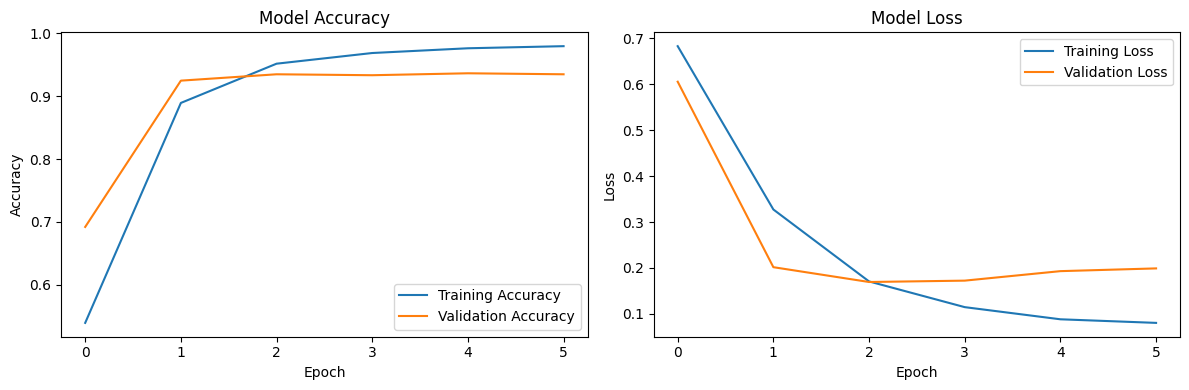

In [80]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history_bilstm)

# GRU

In [81]:
from tensorflow.keras.layers import GRU

model_gru = Sequential()
model_gru.add(Embedding(input_dim=VOCAB_SIZE, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH))
model_gru.add(Bidirectional(GRU(64)))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

model_gru.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_gru.summary()

# Train GRU model
print("\nTraining GRU Model...")
history_gru = model_gru.fit(
    X_train_pad, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_pad, y_test),
    verbose=1
)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 150, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_40                │ (None, 128)            │        74,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,478,657 (24.71 MB)

 Trainable params: 6,478,657 (24.71 MB)

 Non-trainable params: 0 (0.00 B)


Training GRU Model...
Epoch 1/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8243 - loss: 0.3518 - val_accuracy: 0.9420 - val_loss: 0.1438
Epoch 2/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9740 - loss: 0.0772 - val_accuracy: 0.9392 - val_loss: 0.1570
Epoch 3/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9853 - loss: 0.0413 - val_accuracy: 0.9407 - val_loss: 0.1859
Epoch 4/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9902 - loss: 0.0255 - val_accuracy: 0.9369 - val_loss: 0.2828
Epoch 5/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9907 - loss: 0.0211 - val_accuracy: 0.9373 - val_loss: 0.3023
Epoch 6/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9915 - loss: 0.0180 - val_accuracy: 0.9350 - val_loss: 0.2932
Epoch 7/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9927 - loss: 0.0168 - val_accuracy: 0.9351 - val_loss: 0.2868
Epoch 8/8
710/710 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9930 - 

In [82]:
# Evaluate GRU model
loss_gru, accuracy_gru = model_gru.evaluate(X_test_pad, y_test, verbose=1)
print(f"\nTest Accuracy (GRU): {accuracy_gru*100:.2f}%")

# Get predictions
y_pred_probs_gru = model_gru.predict(X_test_pad)
y_pred_gru = (y_pred_probs_gru > 0.5).astype(int)

# Print classification report
print("\nClassification Report (GRU):")
print(classification_report(y_test, y_pred_gru, target_names=['negative', 'positive']))

355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9343 - loss: 0.3690

Test Accuracy (GRU): 93.43%
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report (GRU):
              precision    recall  f1-score   support

    negative       0.94      0.93      0.93      5656
    positive       0.93      0.94      0.93      5703

    accuracy                           0.93     11359
   macro avg       0.93      0.93      0.93     11359
weighted avg       0.93      0.93      0.93     11359

